In [2]:
using Plots
using XLSX
using JuMP
using Ipopt
using Statistics

### Part IV
#### Question 1
Using Mathematica (we will need to show seperation of variables in the paper) we find that the general solution for the heat equation on a radially symettric ball is:
$$u(r,t) = T_b + \sum_{n=1}^{\infty} \frac{2 \cdot (-1)^n exp[\frac{-k\pi^2 tn^2}{R^2}] \cdot R \cdot (T_b-T_r) \cdot sin(\frac{\pi r n}{R})}{\pi r n}$$

In [3]:
function u(r,t,k,tb,tr,R)
    if(typeof(r) != Float64)
        sol = fill(tb, length(r))
    else
        sol = fill(tb, length(t))
    end
    
    for n ∈ (1:25) #taking first 25 modes as an approximation
        sol += (2 .* (-1).^n .* ℯ.^(-k .* π.^2 .* t .* n.^2 ./ R.^2) .* R .* (tb-tr) .* sin.(π .* r .* n ./ R)) ./ 
        (π .* r .* n)
    end
    return(sol)
end

u (generic function with 1 method)

In [4]:
R = 2.5*2.52/100.0
r = LinRange(1e-4,R,250)
t = [0.25,1.0,3.0,10.0,30.0,100.0]
k = 50.0/7850.0/450.0 #engineering toolbox
tb = 273.0
tr = 273.0+22.0
res = zeros((length(t),250))
for i ∈ (1:length(t))
    res[i,:] = u(r,t[i],k,tb,tr,R)
end

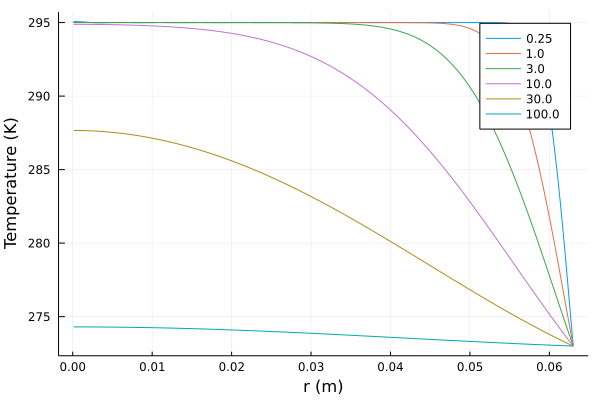

In [5]:
plot(r,res[1,:], label = t[1])
for i ∈ (2:length(t)-1)
    plot!(r,res[i,:], label = t[i])
end
plot!(r,res[length(t),:], label = t[length(t)], xlabel = "r (m)", ylabel = "Temperature (K)")

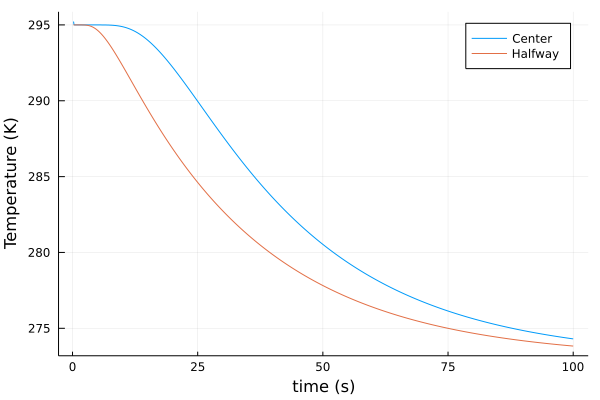

In [6]:
cent = 1e-4
mid = R/2.0
t = LinRange(0.2,100,1001)
centRes = u(cent,t,k,tb,tr,R)
midRes = u(mid,t,k,tb,tr,R)
plot(t,centRes, label = "Center")
plot!(t,midRes, label = "Halfway", xlabel = "time (s)", ylabel = "Temperature (K)")

#### Question 2
First we will read in the data from the excel sheets. Then we will use the non-linear solver Ipopt published by COIN-OR to find the experimental k values and then compare them to the theoretical ones we find on engineering toolbox. 

In [44]:
function kVal(R, rSmall, rMid, tb, tr, start, N, time, center, halfway)
    model = Model(with_optimizer(Ipopt.Optimizer))
    set_silent(model)
    @variable(model, k)
    @NLconstraint(model, k >= 1e-9)
    @NLconstraint(model, k <= 1e-4)
    
    @NLexpressions(model, 
    begin
        sol1Mat[h = 1:N+1, i = 1:25], ((2 * (-1)^i*exp(-k * π^2 * time[h] * i^2 / R^2) * R * (tb - tr) * 
            sin(π * rSmall * i / R)) / (π *rSmall* i))
        
        sol2Mat[h = 1:N+1, i = 1:25], ((2 * (-1)^i*exp(-k * π^2 * time[h] * i^2 / R^2) * R * (tb - tr) * 
            sin(π * rMid * i / R)) / (π *rMid* i)) 
        
        sol1Vec[h = 1:N+1], sum(sol1Mat[h,i] for i in 1:25)
        sol2Vec[h = 1:N+1], sum(sol2Mat[h,i] for i in 1:25)
            
        sol1VecU[h = 1:N+1], sol1Vec[h] + tb
        sol2VecU[h = 1:N+1], sol2Vec[h] + tb
        
        sol1Update[h = 1:N+1], (sol1VecU[h] - center[h])^2 #using mean squared error with L2 norm
        sol2Update[h = 1:N+1], (sol2VecU[h] - halfway[h])^2
        
        sol1, sum(sol1Update[h] for h in 1:N+1)
        sol2, sum(sol2Update[h] for h in 1:N+1)
        solAvg, (sol1+sol2)/2
    end)
    
    @NLobjective(model, Min, solAvg)
    optimize!(model)
    return(value(k))
end

kVal (generic function with 1 method)

In [62]:
rChrome = 2.5*2.52/100/2
mBig = XLSX.readdata("BigSphere.xlsx", "Sheet1!A2:C957")
chromeTemp = mBig[1,2]
start = 5
N = 800
time = mBig[start:start+N,1] 
center = mBig[start:start+N,2]
halfway = mBig[start:start+N,3]
kChrome = kVal(rChrome, 1e-5, rChrome/2, 0.0, chromeTemp, start, N, time, center, halfway)
print("The calculated K value for the large chrome steel ball is: ", kChrome, "\n")
print("The theoretical K value for the large chrome steel ball is: ", 50.0/7850.0/450.0) #engineering toolbox data

The calculated K value for the large chrome steel ball is: 3.3265806166851353e-6
The theoretical K value for the large chrome steel ball is: 1.4154281670205239e-5

In [59]:
rStainless = 1.875*2.52/100/2
mSmall = XLSX.readdata("SmallSphere.xlsx", "Sheet1!A2:C750")
stainlessTemp = mSmall[1,2]
start = 5
N = 700
time = mSmall[start:start+N,1] 
center = mSmall[start:start+N,2]
halfway = mSmall[start:start+N,3]
kStainless = kVal(rStainless, 1e-5, rStainless/2, 0.0, stainlessTemp, start, N, time, center, halfway)
print("The calculated K value for the small stainless steel ball is: ", kStainless, "\n")
print("The theoretical K value for the small stainless steel ball is: ", 14.4/468.0/7750.00)
mSmall[1,2]

The calculated K value for the small stainless steel ball is: 2.1347008627177414e-6
The theoretical K value for the small stainless steel ball is: 3.970223325062035e-6

22.02900000000001

In [61]:
rChrome

0.0315

#### Question 3
We will now use the u equation above to find how long it will take to cool these different spheres down to 3 degrees celcius.

In [47]:
time = LinRange(1e-4,200,2001)
vecChromeCenter = u(1e-5, time, kChrome, 0, chromeTemp, rChrome)
vecChromeMid = u(rChrome/2, time, kChrome, 0, chromeTemp, rChrome)
vecStainlessCenter = u(1e-4, time, kStainless, 0, stainlessTemp, rStainless)
vecStainlessMid = u(rStainless/2, time, kStainless, 0, stainlessTemp, rStainless)
big = hcat(vecChromeCenter, vecChromeMid, vecStainlessCenter, vecStainlessMid)

temp = zeros(4)
switch = [false, false, false, false]

for i ∈ (1:2001)
    for j ∈ (1:4)
        if(!switch[j] && (big[2001-i,j] > 3.0))
            temp[j] = time[2001-i]
            switch[j] = true
        end
    end
end

In [48]:
print("time for the center of the chrome ball to get to 3 degrees ", temp[1], " seconds \n")
print("time for midway of the chrome ball to get to 3 degrees ", temp[2], " seconds \n")
print("time for the center of the stainless ball to get to 3 degrees ", temp[3], " seconds \n")
print("time for midway of the stainless ball to get to 3 degrees ", temp[4], " seconds")

time for the center of the chrome ball to get to 3 degrees 75.10006245 seconds 
time for midway of the chrome ball to get to 3 degrees 61.4000693 seconds 
time for the center of the stainless ball to get to 3 degrees 71.10006444999999 seconds 
time for midway of the stainless ball to get to 3 degrees 59.200070399999994 seconds

#### Question 4


In [49]:
function uModes(r,t,k,tb,tr,R)
    if(typeof(r) != Float64)
        l = length(r)
        sol = zeros((l,26))
        sol[:,1] = fill(tb,l)
        for i ∈ (1:l), n ∈ (1:25)
            sol[i,n+1] = (2*(-1)^n * ℯ^(-k*π^2*t*n^2/R^2) * R * (tb-tr) * sin(π*r[i]*n/R)) / (π*r[i]*n)
        end
        return(sol)
    else
        l = length(t)
        sol = zeros((length(t),26))
        sol[:,1] = fill(tb,length(t))
        for i = 1:l, n = 1:25
            sol[i,n+1] = (2*(-1)^n * ℯ^(-k*π^2*t[i]*n^2/R^2) * R * (tb-tr) * sin(π*r*n/R)) / (π*r*n)
        end
        return(sol)
    end
end

uModes (generic function with 1 method)

In [50]:
time = LinRange(1.0,126.0,501)
centerDataChrome = uModes(1e-4,time,kChrome,0.0,chromeTemp,rChrome)
midDataChrome = uModes(rChrome/2,time,kChrome,0.0,chromeTemp,rChrome)
centerDataStainless = uModes(1e-4,time,kStainless,0.0,stainlessTemp,rStainless)
midDataStainless = uModes(rStainless/2,time,kStainless,0.0,stainlessTemp,rStainless)
print('\n')

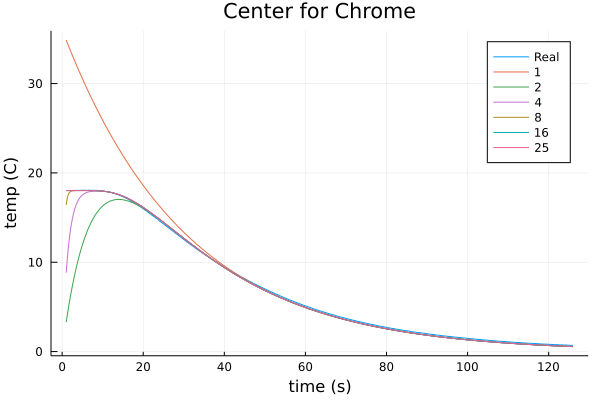

In [51]:
start = 5
N = 500
timeBig = mBig[start:start+N,1] 
centerBig = mBig[start:start+N,2]
halfwayBig = mBig[start:start+N,3]
timeSmall = mSmall[start:start+N,1]
centerSmall = mSmall[start:start+N,2]
halfwaySmall = mSmall[start:start+N,3]
nodes = [1,2,4,8,16,25]

plot(timeBig,centerBig, label = "Real")
for i ∈ (1:6)
    n = nodes[i]
    est = centerDataChrome[:,1]
    for j ∈ (1:n)
        est = est .+ centerDataChrome[:,j+1]
    end
    plot!(timeBig, est, label = n)
end
plot!(title = "Center for Chrome", ylabel = "temp (C)", xlabel = "time (s)")

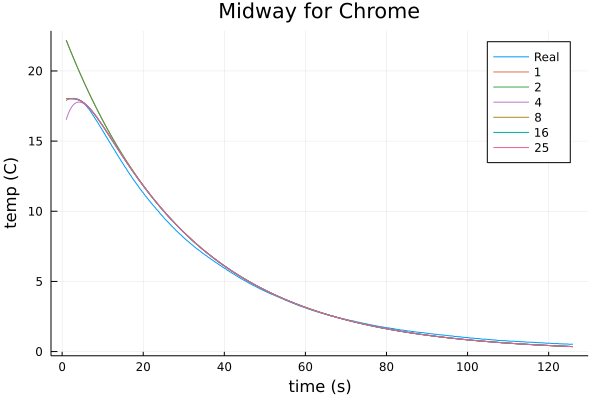

In [52]:
plot(timeBig,halfwayBig, label = "Real")
for i ∈ (1:6)
    n = nodes[i]
    est = midDataChrome[:,1]
    for j ∈ (1:n)
        est = est .+ midDataChrome[:,j+1]
    end
    plot!(timeBig, est, label = n)
end
plot!(title = "Midway for Chrome", ylabel = "temp (C)", xlabel = "time (s)")

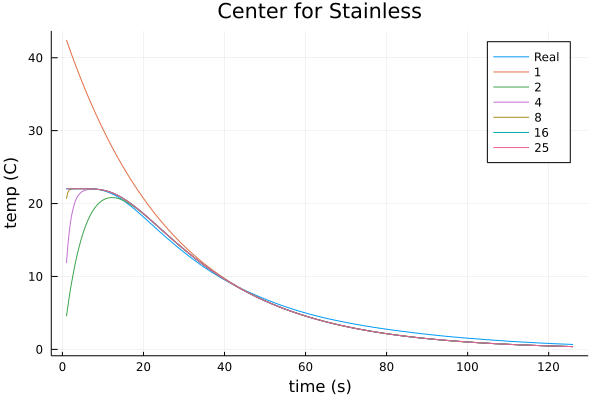

In [53]:
plot(timeSmall,centerSmall, label = "Real")
for i ∈ (1:6)
    n = nodes[i]
    est = centerDataStainless[:,1]
    for j ∈ (1:n)
        est = est .+ centerDataStainless[:,j+1]
    end
    plot!(timeSmall, est, label = n)
end
plot!(title = "Center for Stainless", ylabel = "temp (C)", xlabel = "time (s)")

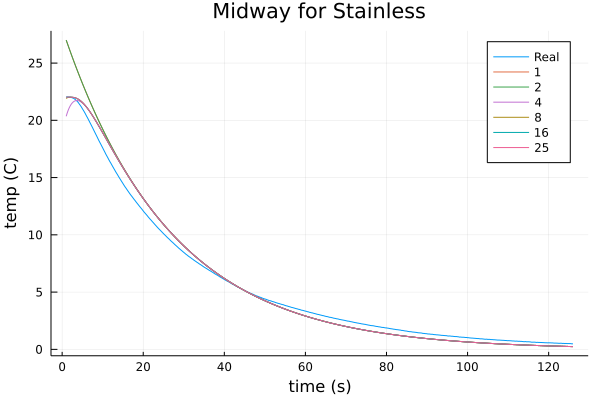

In [54]:
plot(timeSmall,halfwaySmall, label = "Real")
for i ∈ (1:6)
    n = nodes[i]
    est = midDataStainless[:,1]
    for j ∈ (1:n)
        est = est .+ midDataStainless[:,j+1]
    end
    plot!(timeSmall, est, label = n)
end
plot!(title = "Midway for Stainless", ylabel = "temp (C)", xlabel = "time (s)")

#### Part 5
We will now pull in the data for the liquid nitrogen run and then look at the data for the two regiemes of film and nucliate boiling

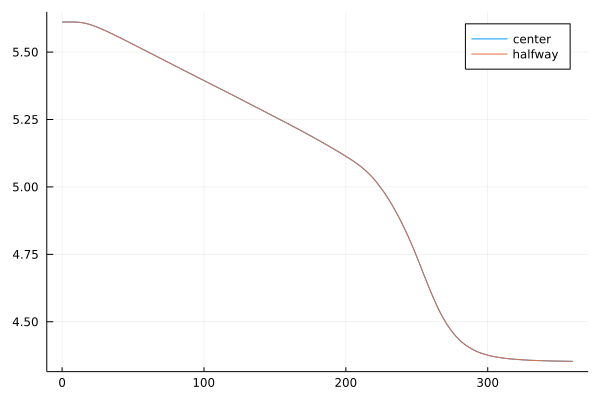

In [55]:
mNitrogen = XLSX.readdata("SmallSphereNitrogen.xlsx", "Sheet1!A2:C1442")
timeNitrogen = mNitrogen[:,1]
centerNitrogen = mNitrogen[:,2] .+ 273.0
midNitrogen = mNitrogen[:,3] .+ 273.0
plot(timeNitrogen, log.(centerNitrogen), label = "center")
plot!(timeNitrogen, log.(centerNitrogen), label = "halfway")

We can see we should set the time for the first regieme from 50 to 200 seconds and the second regieme from 220 to 280 seconds

In [34]:
start = 201
N = 600
time = mNitrogen[start:start+N,1] 
center = mNitrogen[start:start+N,2] .+ 273.0
halfway = mNitrogen[start:start+N,3] .+ 273.0
kNitrogen1 = kVal(rStainless, 1e-5, rStainless/2, 77.0, 0.0, start, N, time, center, halfway)
print("The calculated K value for the film boiling regieme is: ", kNitrogen1, "\n")

start = 881
N = 240
time = mNitrogen[start:start+N,1] 
center = mNitrogen[start:start+N,2] .+ 273.0
halfway = mNitrogen[start:start+N,3] .+ 273.0
kNitrogen2 = kVal(rStainless, 1e-5, rStainless/2, 77.0, mNitrogen[881,2]+273.0, start, N, time, center, halfway)
print("The calculated K value for the nucliate boiling regieme is: ", kNitrogen2, "\n")

The calculated K value for the film boiling regieme is: 3.096537967151152e-5
The calculated K value for the nucliate boiling regieme is: 5.3445060440118914e-5


The thermal diffusivity values are much higher for both regiemes than the water value, but the film boiling regieme is closer to the value found in part 2. 

In [67]:
mNitrogen[1,2]+273.15

273.69599999999997